In [31]:
from scipy.io import mmread
import networkx as nx
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import leidenalg as la
import igraph as ig

In [32]:
data_path = './data/'

enron_path = f'{data_path}/email-enron/email-enron-only.mtx'
univ_path = f'{data_path}/email-univ/email-univ.edges'


In [33]:
# assume undirected graph
def read_adj_file(file, skip_rows: int = 0):
    lines = []
    with open(file, 'r') as f:
        lines = f.readlines()

    E = np.asarray([l.split() for l in lines[skip_rows:]]).astype(int)
    # index from 0
    E = E - E.min()

    adj = np.zeros((E.max() + 1, E.max() + 1))

    for (u,v) in E:
        adj[u, v] = 1
        adj[v, u] = 1

    return adj


# Load datasets

In [34]:
# not in standard mtx format
g_univ = nx.Graph(read_adj_file(univ_path))
g_univ.number_of_nodes(), g_univ.number_of_edges(), g_univ.is_directed()

(1133, 5451, False)

In [35]:
g_enron = nx.Graph(mmread(enron_path).toarray())
g_enron.number_of_nodes(), g_enron.number_of_edges(), g_enron.is_directed()

(143, 623, False)

In [36]:
g_karate = nx.karate_club_graph()
g_karate.number_of_nodes(), g_karate.number_of_edges(), g_karate.is_directed()

(34, 78, False)

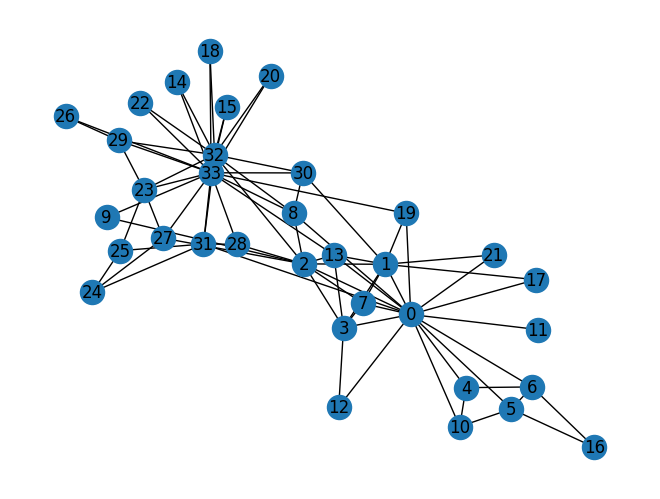

In [37]:
nx.draw(g_karate, with_labels=True)

# Define Metrics for comparison

In [38]:
def community_metrics(graph, labels):
    """
    Calculate community metrics for a given graph and set of labels.

    Parameters:
    - graph: The input graph (NetworkX graph object).
    - labels: A dictionary mapping node IDs to community labels.

    Returns:
    - A dictionary containing the calculated metrics:
        - "Modularity": The modularity score of the community partition.
        - "Number of Communities": The number of detected communities.
        - "Average Community Size": The average size of the communities.
    """
    # Group nodes by community
    communities = {}
    for node, label in labels.items():
        if label not in communities:
            communities[label] = []
        communities[label].append(node)
    community_list = list(communities.values())

    # Calculate modularity
    mod = nx.algorithms.community.modularity(graph, community_list)

    # Coverage and performance
    coverage, performance = nx.algorithms.community.partition_quality(graph, community_list)
    
    # Number of communities
    num_communities = len(community_list)
    
    # Average community size
    avg_community_size = sum(len(community) for community in community_list) / num_communities
    
    return {
        "Number of Communities": num_communities,
        "Average Community Size": avg_community_size,
        "Modularity": mod,
        "Coverage": coverage,
        "Performance": performance,
    }

# Plotting of resulting communities

In [39]:
def plot_communities(G, node_community_labels, title="Communities"):
    plt.figure(figsize=(15, 7))
    pos = nx.spring_layout(G, seed=42)

    nx.draw(G, pos, node_color=list(node_community_labels.values()), with_labels=True, cmap=plt.cm.Set3)
    plt.title(title)

    plt.show()

# Apply Label Propagation

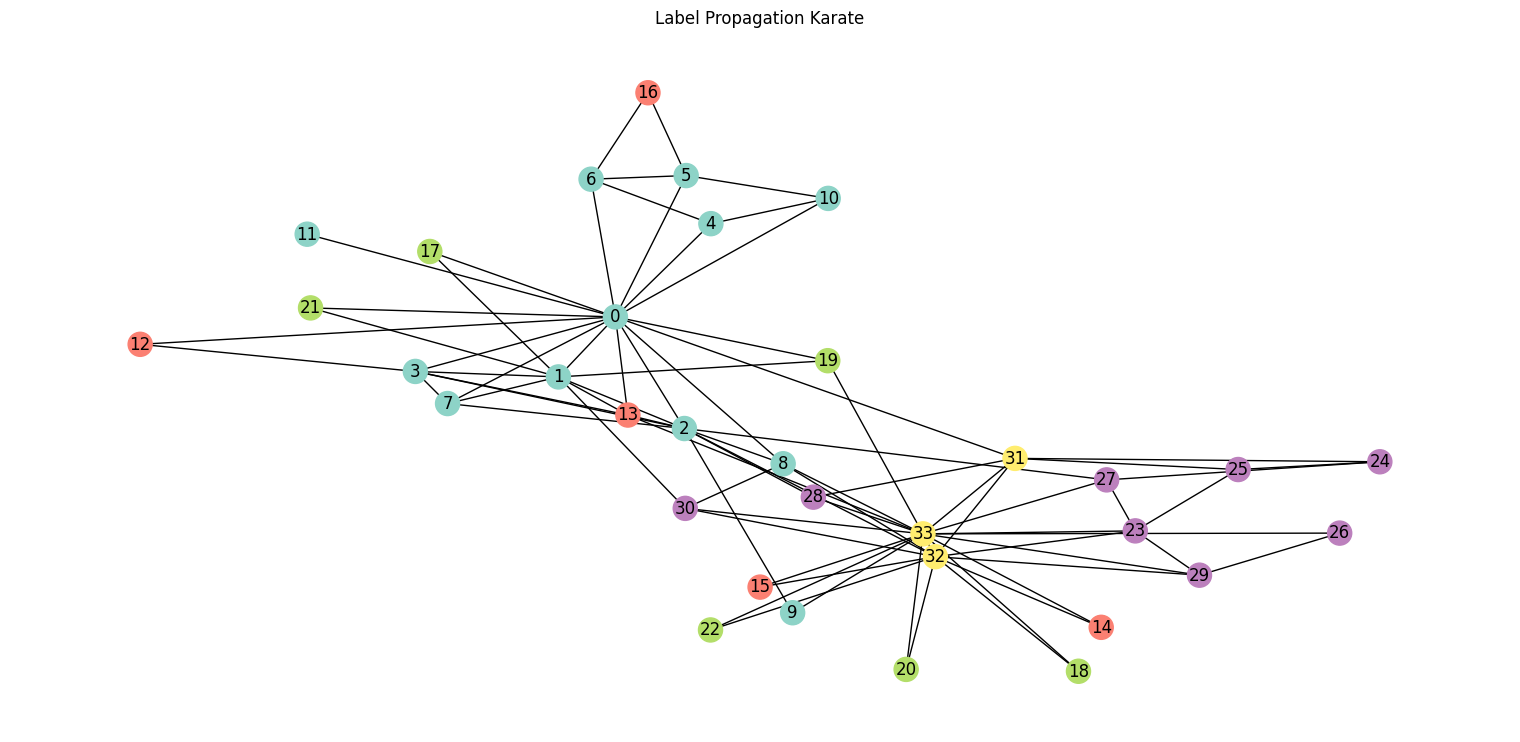

{'Number of Communities': 5,
 'Average Community Size': 6.8,
 'Modularity': 0.31018908940986867,
 'Coverage': 0.5641025641025641,
 'Performance': 0.8003565062388592}

In [62]:
lp_communities = nx.algorithms.community.label_propagation_communities(g_karate)
lp_labels = {}
for i, community in enumerate(lp_communities):
    for node in community:
        lp_labels[node] = i

plot_communities(g_karate, lp_labels, title="Label Propagation Karate")

# Calculate metrics for Louvain
lp_metrics = community_metrics(g_karate, lp_labels)
lp_metrics

# Apply Louvain

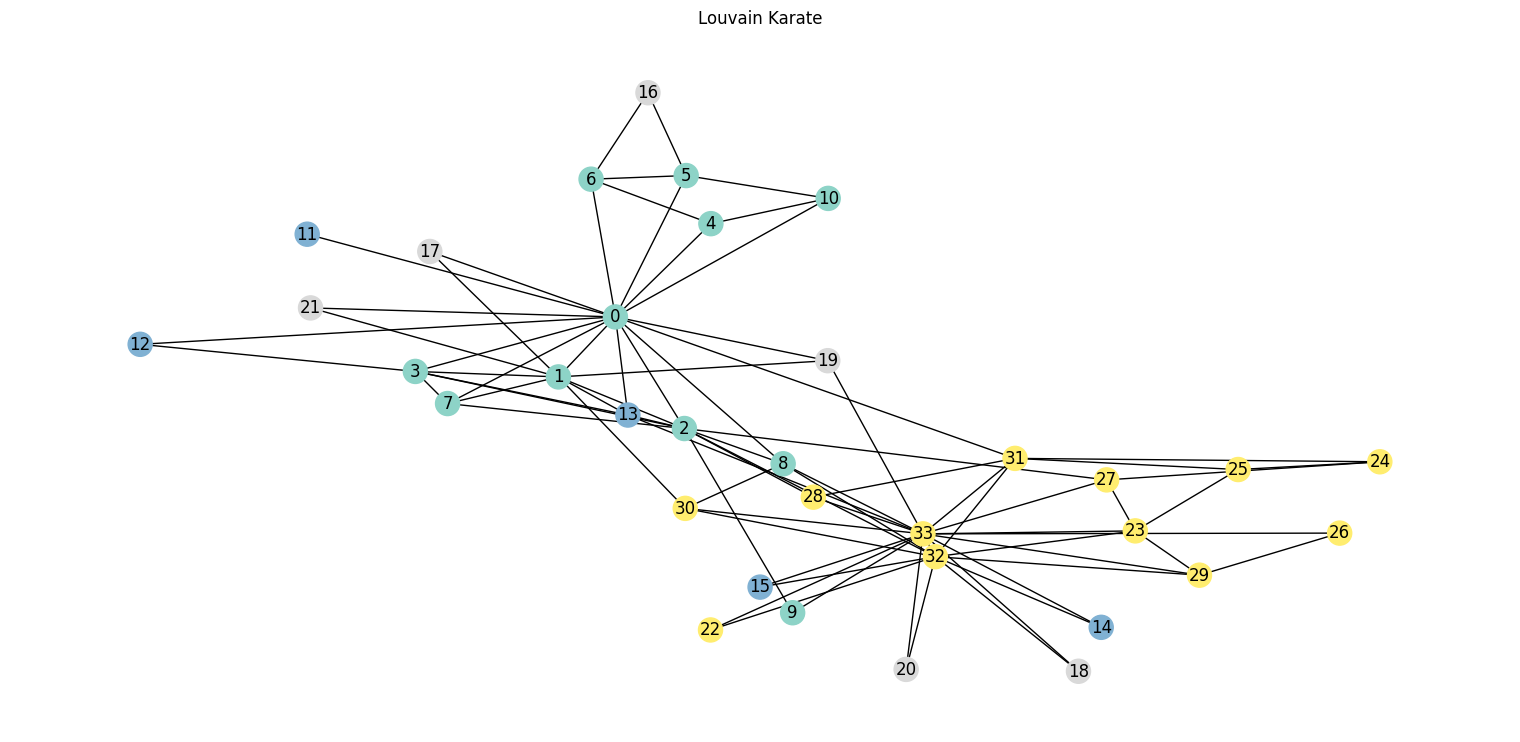

{'Number of Communities': 4,
 'Average Community Size': 8.5,
 'Modularity': 0.44490358126721763,
 'Coverage': 0.7307692307692307,
 'Performance': 0.803921568627451}

In [119]:
lv_communities = nx.algorithms.community.louvain_communities(g_karate)
lv_labels = {}

# if str(type(lv_communities)) == "<class 'generator'>":
#     lv_communities = [c for c in lv_communities][-1]

for i, community in enumerate(lv_communities):
    for node in community:
        lv_labels[node] = i

plot_communities(g_karate, lv_labels, title="Louvain Karate")

# Calculate metrics for Louvain
lv_metrics = community_metrics(g_karate, lv_labels)
lv_metrics

# Apply Leiden

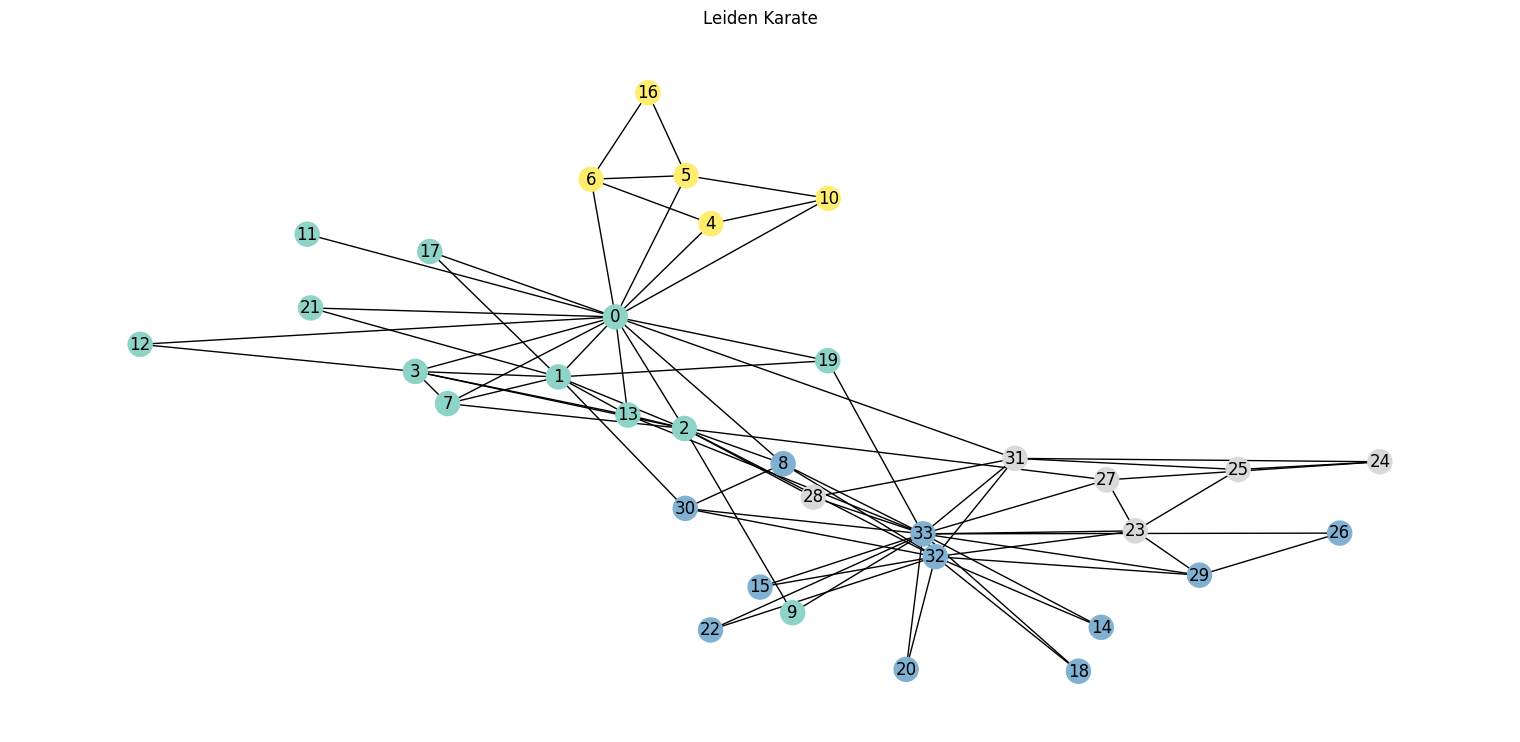

{'Number of Communities': 4,
 'Average Community Size': 8.5,
 'Modularity': 0.440181031090122,
 'Coverage': 0.7307692307692307,
 'Performance': 0.803921568627451}

In [120]:
ig_graph = ig.Graph.from_networkx(g_karate)
leiden_partition = la.find_partition(ig_graph, la.RBConfigurationVertexPartition)
ld_labels = {node: part for node, part in zip(g_karate.nodes(), leiden_partition.membership)}

plot_communities(g_karate, ld_labels, title="Leiden Karate")

# Calculate metrics for Louvain
ld_metrics = community_metrics(g_karate, ld_labels)
ld_metrics

# Apply GAT Embedding

In [43]:
import os
os.environ["DGLBACKEND"] = "pytorch"

# GAT Clustering

In [44]:
import dgl
import torch
import torch.nn.functional as F
from dgl.nn import GATConv
from dgl.data import KarateClubDataset

# Load the Karate Club dataset
dataset = KarateClubDataset()
graph = dataset[0]

# Add self-loops
graph = dgl.add_self_loop(graph)

# Define GAT model
class GAT(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = GATConv(in_dim, hidden_dim, num_heads)
        self.layer2 = GATConv(hidden_dim * num_heads, out_dim, 1)  # Output layer with 1 head

    def forward(self, graph, inputs):
        h = self.layer1(graph, inputs)
        h = F.elu(h)
        h = h.view(h.shape[0], -1)  # Flatten the output of multi-head attention
        h = self.layer2(graph, h)
        h = h.mean(1)  # Average over the heads
        return h

# Model parameters
in_dim = graph.ndata['feat'].shape[1]
hidden_dim = 8
out_dim = dataset.num_classes
num_heads = 4  # Number of attention heads
model = GAT(in_dim, hidden_dim, out_dim, num_heads)

# Training setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 100
model.train()

for epoch in range(num_epochs):
    logits = model(graph, graph.ndata['feat'])
    loss = loss_fn(logits[graph.ndata['label']], graph.ndata['label'])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(graph, graph.ndata['feat'])
    pred = logits.argmax(1)
    accuracy = (pred == graph.ndata['label']).float().mean()
    print(f'Accuracy: {accuracy.item():.4f}')

# Visualize the results
import matplotlib.pyplot as plt
import networkx as nx

nx_graph = graph.to_networkx().to_undirected()
pos = nx.spring_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=pred.numpy(), cmap=plt.cm.Set3)
plt.show()

KeyError: 'feat'

In [124]:
dgl.data.KarateClubDataset().features

AttributeError: 'KarateClubDataset' object has no attribute 'features'